In [1]:
import struct

# see CDAS git /Raid/src/Utils/CL/cl_msg_unknown_pack.h
def read_package(f) -> dict:

    package = {}
    rv = None, None

    # pack Header
    LsId = int.from_bytes(f.read(2), byteorder='little')
    n_packs = int.from_bytes(f.read(2), byteorder='little')
    timestamp_sec = int.from_bytes(f.read(4), byteorder='little')
    timestamp_nsec = int.from_bytes(f.read(4), byteorder='little')
    total_size = int.from_bytes(f.read(4), byteorder='little')

    for i in range(n_packs):

        # header i
        type = int.from_bytes(f.read(4), byteorder='little')
        version = int.from_bytes(f.read(4), byteorder='little')
        size = int.from_bytes(f.read(4), byteorder='little')
        data = f.read(size)

        # package[str(i)] = {'type': type,
        #                 'version': version,
        #                 'size': size,
        #                 'data': data}

        # only return the data we're interested in
        if type == 8 and version == 2:
            rv = LsId, data
    
    return rv

before_official_daq = [] 
with open('/home/filip/Desktop/monitoring_packs/monit_2024_12_05.packs.nobackup', 'rb') as f:
    while f.read(8) == b'!monit!!':
        before_official_daq.append(read_package(f))

official_daq = [] 
with open('/home/filip/Desktop/monitoring_packs/monit_2024_12_06.packs.nobackup', 'rb') as f:
    while f.read(8) == b'!monit!!':
        official_daq.append(read_package(f)) 

In [ ]:
import numpy as np

peaks = []
station_id = 136

for e in examples:
        data = e['1']['data']
        peaks.append([struct.unpack('d', data[i:i+8])[0] for i in range(0, len(data), 8)])

peaks = np.array(peaks)

In [ ]:
import matplotlib.pyplot as plt

for i in range(4):
    plt.plot(range(len(peaks)), peaks[:, i], label=i)

plt.legend()

/tmp/ipykernel_36195/3931012190.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=id)


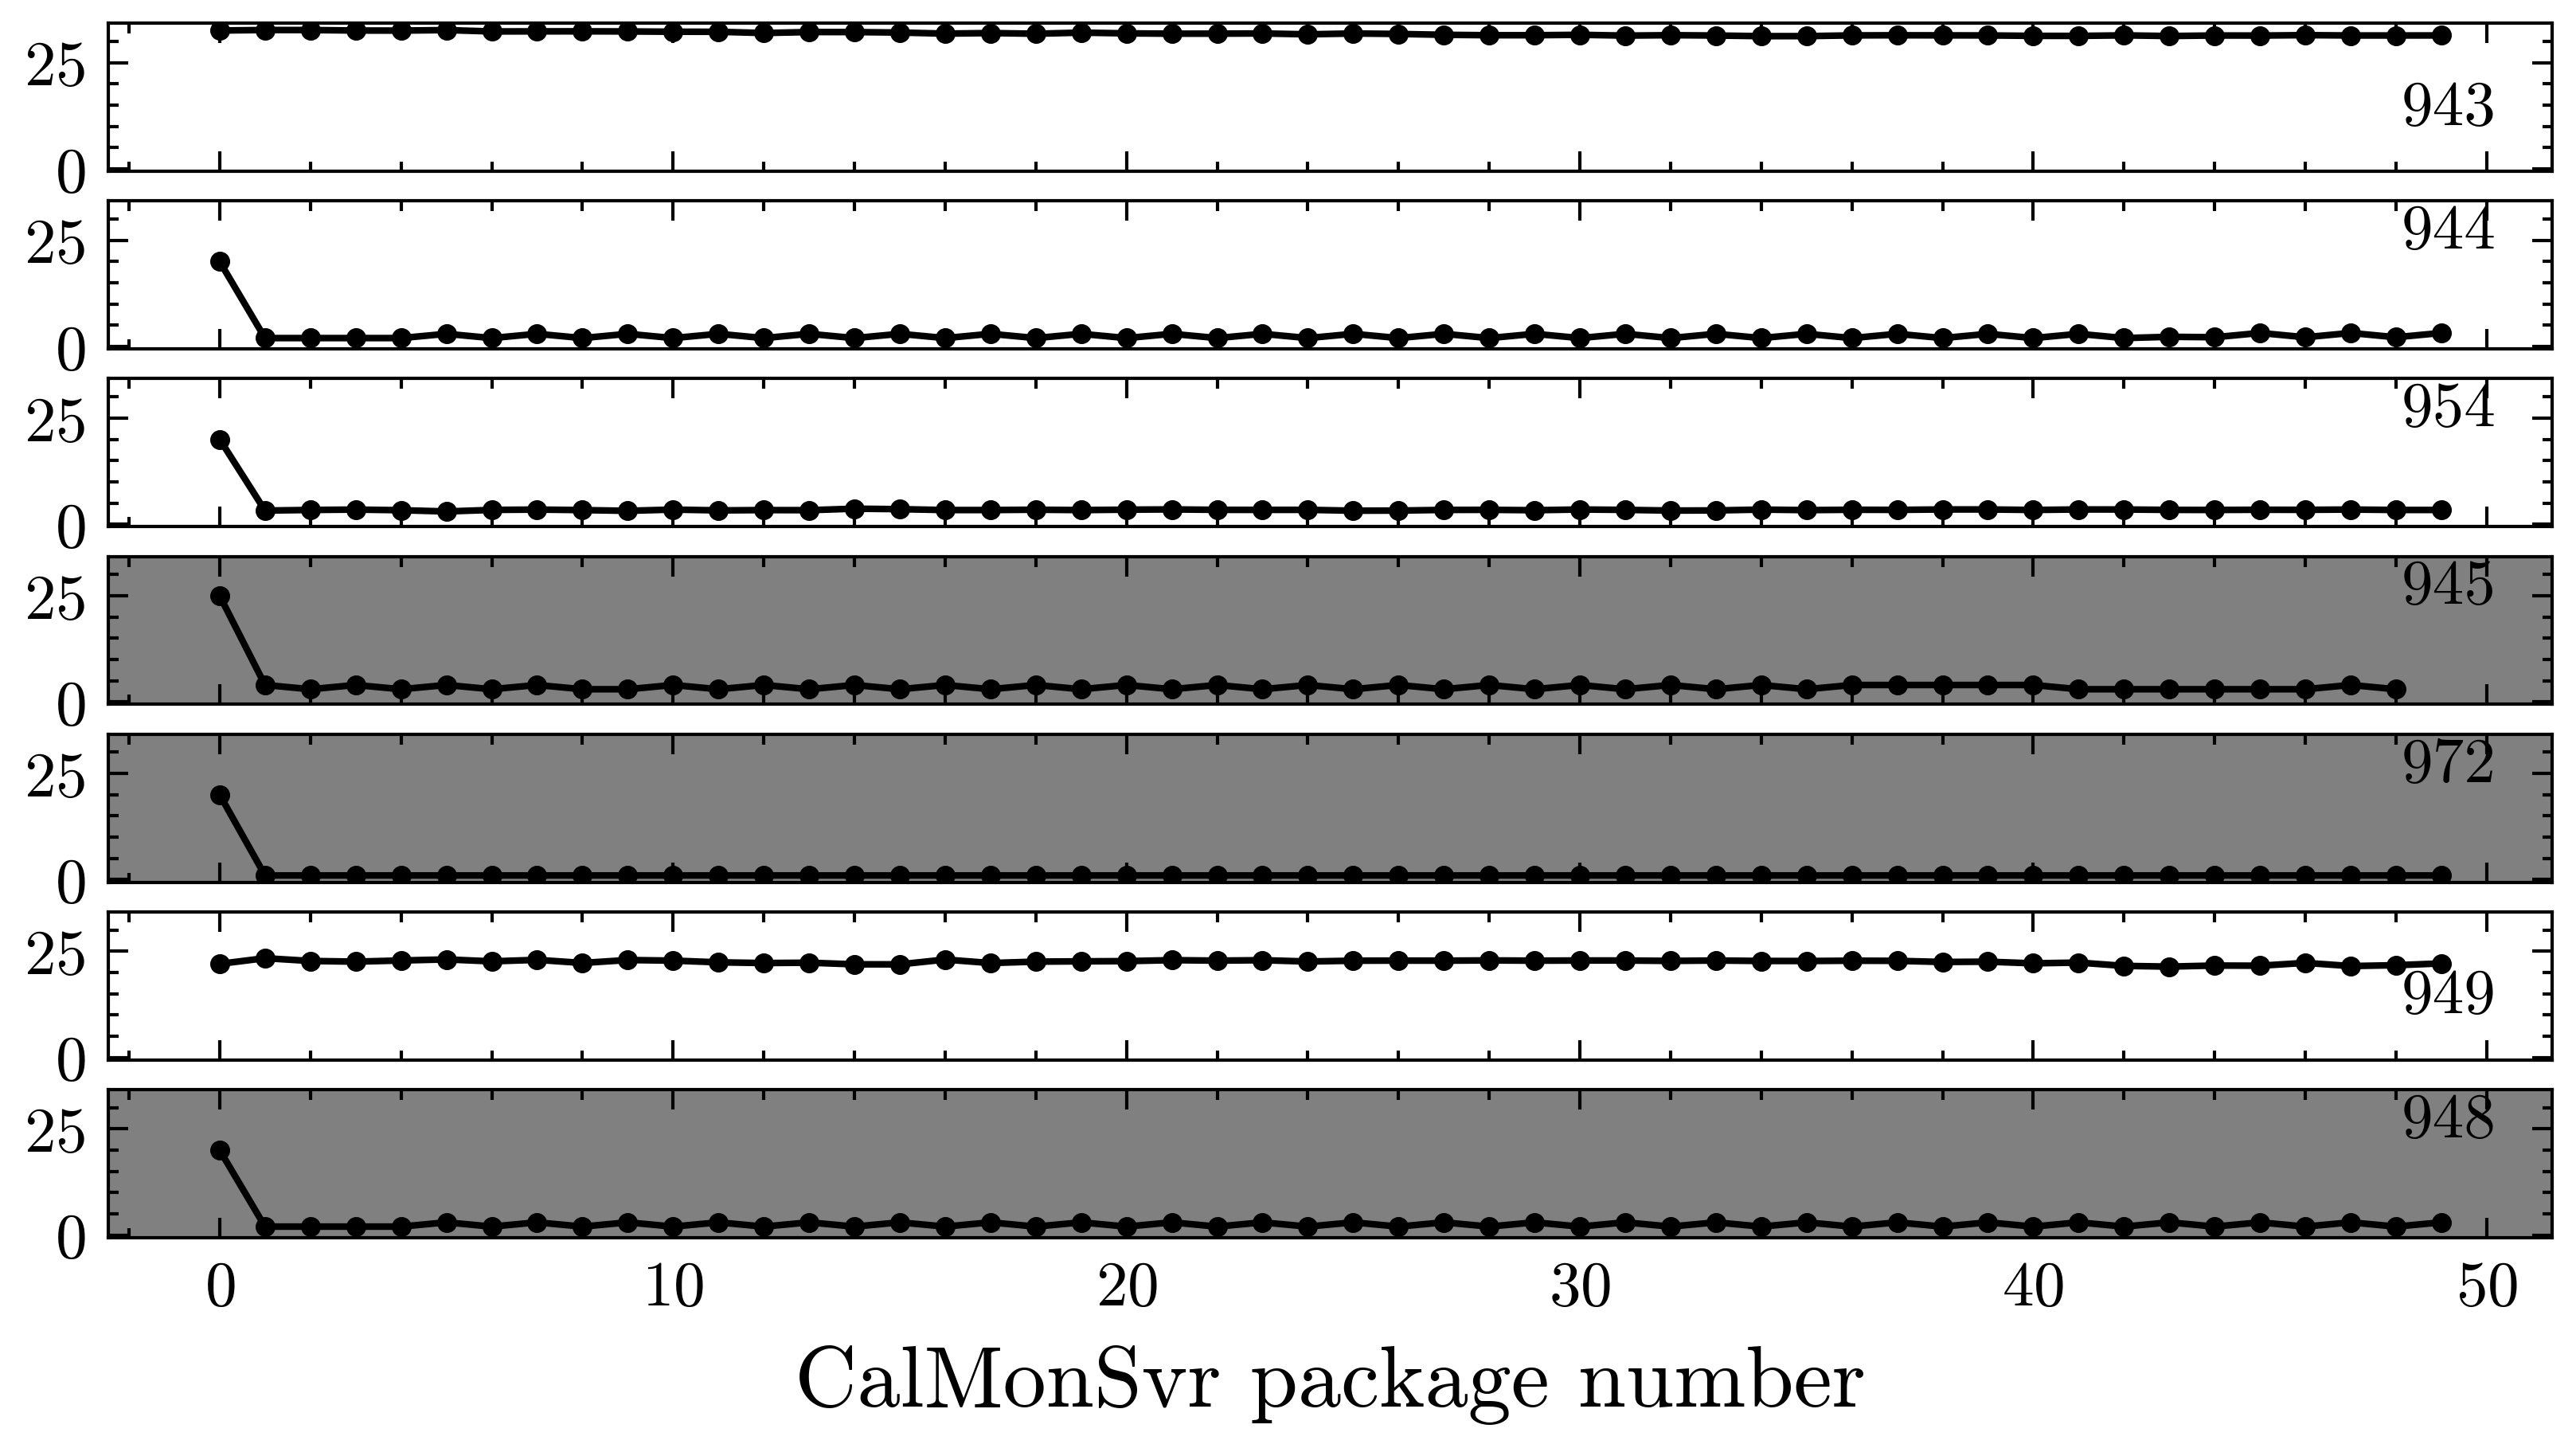

In [ ]:
from utils.binaries import *
from utils.plotting import *

fig, axes = plt.subplots(7, 1, sharex=True, sharey=True)

LsId = [943, 944, 954, 945, 972, 949, 948]
noSSD = ["948", "945", "972"]
peaks = {str(id): [] for id in LsId}

convert = lambda d: [struct.unpack('d', d[i:i+8])[0] for i in range(0, len(d), 8)]

for e in official_daq:
    if e[1] is None: continue
    elif e[0] == 136: continue
    peaks[str(e[0])].append(convert(e[1]))

for (id, val), ax in zip(peaks.items(), axes):
    # for i in range(4):
    #    ax.plot(range(len(val)), np.array(val)[:, i], label=i)

    if id in noSSD: ax.set_facecolor('#808080')
    ax.plot(range(len(val)), np.array(val)[:, 3]/1.17)
    ax.legend(title=id)

_ = ax.set_xlabel("CalMonSvr package number")

In [25]:
print(945 in noSSD)

True
